In [218]:
#Purpose: clean openContext data and store them to cleanedfile, train file and test file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [219]:
def drawDestribution(df, collection):
    fig = plt.figure(figsize=[10,5])
    ax = fig.add_subplot()
    dis = df.value_counts()
    p = ax.barh(dis.keys().str.replace("[^\w\s]", "", regex=True), dis)
    for i, rect in enumerate(dis.index):
        ax.text(dis[rect], i,  dis[rect])
    plt.title(f'OpenContext {collection}')
    plt.xlabel('count')

In [220]:
original = pd.read_csv('../Collections_data/OPENCONTEXT_5000_original.csv')
core = pd.read_csv('../Collections_data/OPENCONTEXT_5000_core.csv')

In [222]:
original = original.drop([original.columns[0]], axis=1)
core = core.drop([core.columns[0]], axis=1)

In [223]:
CVs = core[['uri', 'hasContextCategory', 'hasMaterialCategory', 'hasSpecimenCategory']]

In [224]:
CVs['hasContextCategory'].str.replace("[^\w\s]", "", regex=True).value_counts()/len(CVs)

Site of past human activities    1.0
Name: hasContextCategory, dtype: float64

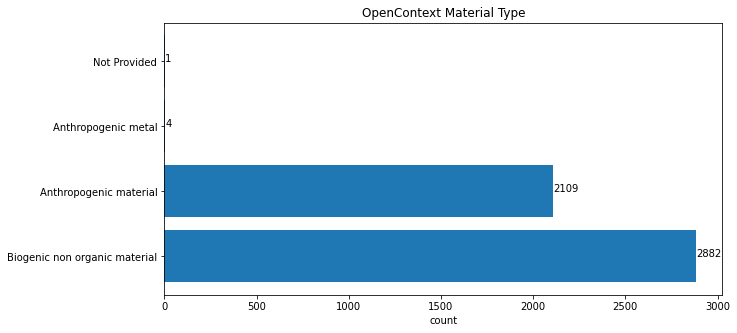

In [225]:
CVs['hasMaterialCategory'].str.replace("[^\w\s]", "", regex=True).value_counts()/len(CVs)
drawDestribution(CVs['hasMaterialCategory'], 'Material Type')

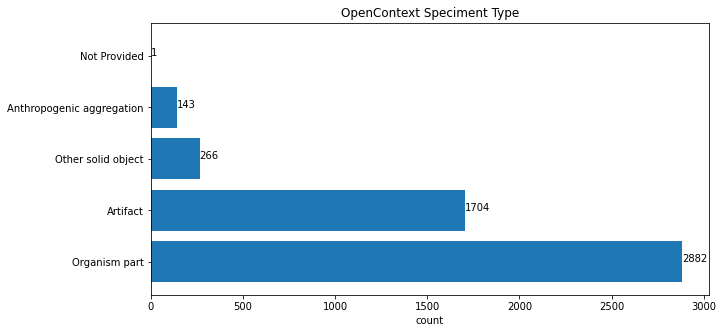

In [226]:
CVs['hasSpecimenCategory'].str.replace("[^\w\s]", "", regex=True).value_counts()/len(CVs)
drawDestribution(CVs['hasSpecimenCategory'], 'Speciment Type')

In [227]:
Nofields = ['label', 'Creator', 'updated', 'latitude', 'longitude', 'published', 'context uri', 'late bce/ce', 'project uri', 'citation uri', 'early bce/ce', 'Contributor']
cleaned = original.drop(Nofields, axis=1)

In [228]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   uri                            5000 non-null   object
 1   context label                  5000 non-null   object
 2   item category                  5000 non-null   object
 3   project label                  5000 non-null   object
 4   Has taxonomic identifier       2418 non-null   object
 5   Has anatomical identification  2417 non-null   object
 6   Temporal Coverage              323 non-null    object
 7   Has type                       142 non-null    object
 8   Consists of                    147 non-null    object
 9   Has former or current keeper   9 non-null      object
 10  Has current location           9 non-null      object
dtypes: object(11)
memory usage: 429.8+ KB


Text(0.5, 0, 'Percentage % (total 5000 records sampled from 820272 records)')

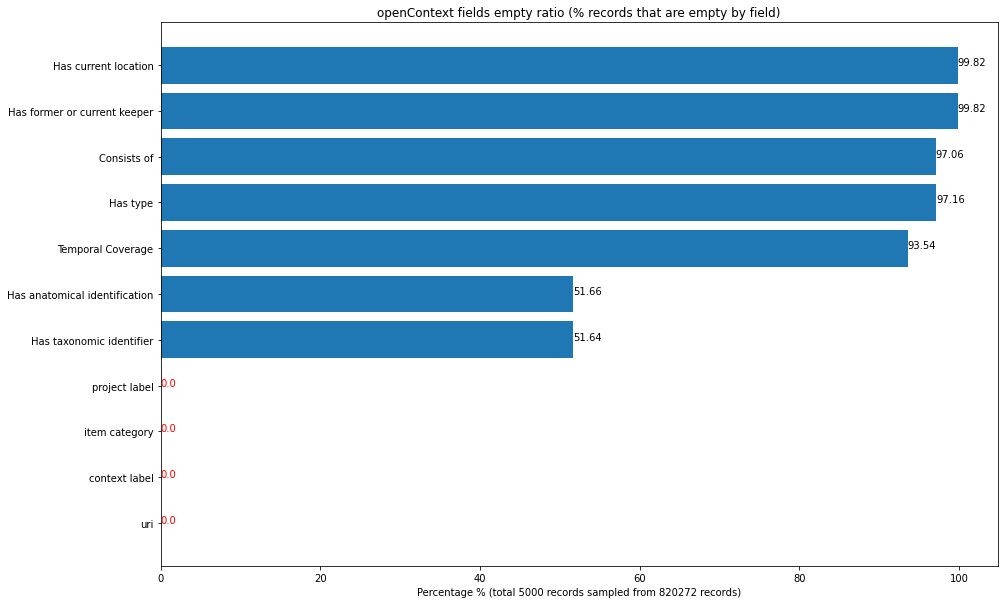

In [229]:
empty_fields = cleaned.isnull().sum()/len(cleaned) * 100
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot()
p = ax.barh(empty_fields.keys(), empty_fields)
for i, rect in enumerate(empty_fields.index):
    ax.text(empty_fields[rect], i,  round(empty_fields[rect], 4), color = 'black' if round(empty_fields[rect], 4) >= 50 else 'red')
plt.title("openContext fields empty ratio (% records that are empty by field)")
plt.xlabel(f'Percentage % (total {len(cleaned)} records sampled from 820272 records)')

In [230]:
cleaned = cleaned.merge(CVs)
cleaned = cleaned.drop(['Has current location','Has former or current keeper'], axis=1)

In [232]:
import ast
pd.set_option('max_colwidth', None, 'display.max_rows', 100)
cleaned['Has anatomical identification'] = cleaned['Has anatomical identification'].apply(lambda x : ' '.join(pd.json_normalize(ast.literal_eval(x))['label'].tolist()) if not pd.isnull(x) else "")
cleaned['Has taxonomic identifier'] = cleaned['Has taxonomic identifier'].apply(lambda x : ' '.join(pd.json_normalize(ast.literal_eval(x))['label'].tolist()) if not pd.isnull(x) else "")
cleaned['Has type'] = cleaned['Has type'].apply(lambda x : ' '.join(pd.json_normalize(ast.literal_eval(x))['label'].tolist()) if not pd.isnull(x) else "")
cleaned['Consists of'] = cleaned['Consists of'].apply(lambda x : ' '.join(pd.json_normalize(ast.literal_eval(x))['label'].tolist()) if not pd.isnull(x) else "")
cleaned['Temporal Coverage'] = cleaned['Temporal Coverage'].apply(lambda x : ' '.join(pd.json_normalize(ast.literal_eval(x))['label'].tolist()) if not pd.isnull(x) else "")

In [233]:
cleaned['text'] = ""
for col in cleaned.columns[1:len(cleaned.columns)-4]:
    cleaned['text'] += cleaned[col] + ' '

In [234]:
cleaned['text'] = cleaned['text'].str.replace('[^\w\s]','', regex=True)
cleaned['text'] = cleaned['text'].str.lower()
cleaned['text'] = cleaned['text'].replace('\s+', ' ', regex=True)

In [235]:
def preprocessing(CV, fields, df):
    info = df[[CV]+fields]
    info[CV] = info[CV].str.replace('[^\w\s]','', regex=True)
    info[CV] = info[CV].str.replace(' ','_', regex=True)
    info[CV] = "__label__" + info[CV]
    info = info.loc[info[CV] != '__label__Not_Provided']
    return info

In [236]:
#OpenContext material type
materialType = preprocessing('hasMaterialCategory', ['text'], cleaned)
materialType = materialType.sample(n=1000, random_state=1)
materialType['fasttext'] = materialType['hasMaterialCategory'] + " " + materialType['text']
train = materialType['fasttext'].sample(frac=0.7, random_state=99) 
test = materialType['fasttext'].loc[~materialType['fasttext'].index.isin(train.index)]
print(len(train), len(test))
materialType['fasttext'].to_csv('../Collections_data/cleanedopenContext_materialType.txt', header=False, index=False)
train.to_csv('../Collections_data/openContexttrain_materialType.train', header=False, index=False)
test.to_csv('../Collections_data/openContextValid_materialType.valid', header=False, index=False)

700 300


C:\Users\gq121\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [238]:
#OpenContext material type, only item category
materialType = preprocessing('hasMaterialCategory', ['item category'], cleaned)
materialType = materialType.sample(n=1000, random_state=1)
materialType['fasttext'] = materialType['hasMaterialCategory'] + " " + materialType['item category']
train = materialType['fasttext'].sample(frac=0.7, random_state=99) 
test = materialType['fasttext'].loc[~materialType['fasttext'].index.isin(train.index)]
print(len(train), len(test))
materialType['fasttext'].to_csv('../Collections_data/cleanedopenContext_materialType_onlyOne.txt', header=False, index=False)
train.to_csv('../Collections_data/openContexttrain_materialType_onlyOne.train', header=False, index=False)
test.to_csv('../Collections_data/openContextValid_materialType_onlyOne.valid', header=False, index=False)

700 300


In [237]:
#OpenContext speciment type
specimenType = preprocessing('hasSpecimenCategory',['text'], cleaned)
specimenType = specimenType.sample(n=1000, random_state=1)
specimenType['fasttext'] = specimenType['hasSpecimenCategory'] + " " + specimenType['text']
train = specimenType['fasttext'].sample(frac=0.7, random_state=99) 
test = specimenType['fasttext'].loc[~specimenType['fasttext'].index.isin(train.index)]
print(len(train), len(test))
specimenType['fasttext'].to_csv('../Collections_data/cleanedopenContext_specimenType.txt', header=False, index=False)
train.to_csv('../Collections_data/openContexttrain_specimenType.train', header=False, index=False)
test.to_csv('../Collections_data/openContextValid_specimenType.valid', header=False, index=False)

700 300


In [239]:
#OpenContext speciment type, only item category
specimenType = preprocessing('hasSpecimenCategory', ['item category'], cleaned)
specimenType = specimenType.sample(n=1000, random_state=1)
specimenType['fasttext'] = specimenType['hasSpecimenCategory'] + " " + specimenType['item category']
train = specimenType['fasttext'].sample(frac=0.7, random_state=99) 
test = specimenType['fasttext'].loc[~specimenType['fasttext'].index.isin(train.index)]
print(len(train), len(test))
specimenType['fasttext'].to_csv('../Collections_data/cleanedopenContext_specimenType_onlyOne.txt', header=False, index=False)
train.to_csv('../Collections_data/openContexttrain_specimenType_onlyOne.train', header=False, index=False)
test.to_csv('../Collections_data/openContextValid_specimenType_onlyOne.valid', header=False, index=False)

700 300
